# Importing libraries

In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import cv2
from skimage.segmentation import mark_boundaries, slic
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import mode
from  scipy import ndimage
import copy

# Loading the dataset and mask

Text(0.5, 1.0, 'Mask')

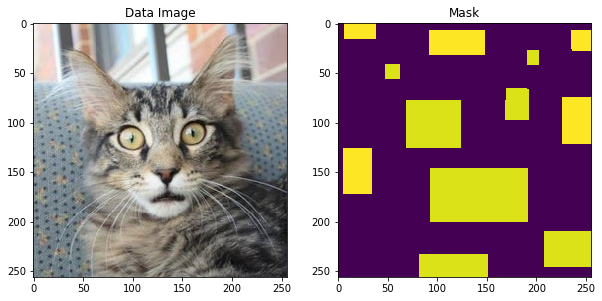

In [207]:
original_image = cv2.imread("dataset/cat3.jpg", -1)
mask = cv2.imread("dataset/cat3 - gt.png", 0)

original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(original_image)
plt.title("Data Image")
ay = fig.add_subplot(1, 2, 2)
ay.imshow(mask)
plt.title("Mask")

# original_image = original_image/255.0

# Functions

In [208]:
def label2idx(L):     
    return [
        np.where(L == i)
        for i in range(1, np.max(L)+1)]

In [209]:
def init_list_of_objects(size):
    list_of_objects = list()
    for i in range(0,size):
        list_of_objects.append( list() ) #different object reference each time
    return list_of_objects

In [210]:
def bhattacharyya(image_, pixelIndexList, a, b):
    a_rows = pixelIndexList[a][0]
    a_cols = pixelIndexList[a][1]
    b_rows = pixelIndexList[b][0]
    b_cols = pixelIndexList[b][1]
    n_layers = image_.shape[2]
    
    mu_1 = np.ravel([np.mean(image_[a_rows, a_cols, i])for i in range(n_layers)])
    mu_2 = np.ravel([np.mean(image_[b_rows, b_cols, i])for i in range(n_layers)])

    sigma_1 = np.cov(np.transpose(image_[a_rows, a_cols, :]))
    sigma_2 = np.cov(np.transpose(image_[b_rows, b_cols, :]))
    sigma = 0.5*(sigma_1 + sigma_2)
    
    if(np.linalg.matrix_rank(sigma_1)<=1 or np.linalg.matrix_rank(sigma_2)<=1 or np.linalg.matrix_rank(sigma)<=1):
        distance = 0
    else:
        A = np.matmul(np.matmul(np.transpose(mu_1 - mu_2),np.linalg.pinv(sigma)),(mu_1 - mu_2))
        t = np.linalg.slogdet(sigma)
        m = np.linalg.slogdet(sigma_1)
        n = np.linalg.slogdet(sigma_2)
        B = t[1] - 0.5*m[1] - 0.5*n[1]
        d = 0.125*A + 0.5*B
        distance = d
    return distance

In [211]:
def neighborSegment(L):

    pixelIndexList = label2idx(L) 
    N = len(pixelIndexList)
    neighborsList = init_list_of_objects(N)
    
    for i in range(1, L.shape[0]-1):#to be checked
        for j in range(1, L.shape[1]-1):#to be checked
            neighbor=[L[i-1,j-1], L[i-1,j], L[i-1,j+1],
                      L[i,j-1],           L[i,j+1],
                      L[i+1,j-1],L[i+1,j],L[i+1,j+1]] #to be checked
            neighbor = [item for item in neighbor if item != L[i,j]]
            if neighbor: # to be optimized
                neighborsList[L[i,j]-1].extend(neighbor)
    
    for k in range(len(neighborsList)):
        neighborsList[k] = np.unique(neighborsList[k])

    return neighborsList

In [212]:
def distanceSegmentswithinfo(image, L):
    # This function takes a segmented image and labels segments and computes 
    # the distance.
    # It returns :
    # - a column for the first segment.
    # - a column for the second segment.
    # - a column for the distance between these two segments.
    # This will help me define the limits in order to choose the threshold
    pixelIndexList = label2idx(L)
    neighborsList = neighborSegment(L)

    distanceList = []
    for a in range(0, len(neighborsList)):
        # a is the index of one segment
        distanceList_elt = np.zeros([1,3])
        for b in range(0, len(neighborsList[a])): 
            # b is the index of another segment neighboring the segment index by a
            distanceList_elt = (int(a+1),int(neighborsList[a][b]), 
                            bhattacharyya(image, pixelIndexList, a, neighborsList[a][b]-1))
            distanceList.append(distanceList_elt)
#             print(distanceList_elt)
    i = 0
    imax = len(distanceList)
    while i<imax:
        segments_pair_1 = [distanceList[i][0], distanceList[i][1]]
        for j in range(i+1, imax):
            segments_pair_2 = [distanceList[j][0], distanceList[j][1]]
            if segments_pair_1[0] == segments_pair_2[1] and segments_pair_1[1] == segments_pair_2[0]:
                distanceList.pop(j)
                break;
        imax = len(distanceList)
        i+=1

    return distanceList

In [213]:
def updateLabels(L):
    remainingElements = np.unique(L)
    
    for p in range(0, len(remainingElements)):
        L = np.where(L==remainingElements[p], p+1, L)
        

    return L

In [214]:
def mergeNeighbor(image, L, t):
    # This function merges the neighbor segments of a superpixel 
    # we get the distance between the segments
    distanceList = distanceSegmentswithinfo(image, L)
    distances = [distanceList[x][2] for x in range(0,len(distanceList))]
    # we get the list of the elements to merge
    mergeList = [i for i,x in enumerate(distances) if x<=t]
    elts2merge = np.array([[distanceList[x][0], distanceList[x][1]]for x in mergeList])
    # merging loop
    k = 0
    while len(mergeList) != 0 and np.max(L) != 1 :
        print('merging stage = ' + str(k))
        while len(elts2merge) != 0 :
            # merge the segments
            L = np.where(L==elts2merge[0][1], elts2merge[0][0], L) # checked
            # replace the merged segment label
            elts2merge[elts2merge[:,1]==elts2merge[0][1],1] = elts2merge[0][0]

            # delete the merged segments from the elements to merge
            elts2merge = np.delete(elts2merge, 0, axis=0) # checked

        L = updateLabels(L)
        distanceList = distanceSegmentswithinfo(image, L)
        distances = [distanceList[x][2] for x in range(0,len(distanceList))]
        mergeList = [i for i,x in enumerate(distances) if x<=t]
        elts2merge = np.array([[distanceList[x][0], distanceList[x][1]]for x in mergeList])
        k+=1

    return L

In [215]:
def get_features_and_labels(image_, mask) :
    data_features = []
    data_labels = []
    
    c = 1
    for l in samples_labels:
        features = image_[mask==l]
        data_features.append(features)
        data_labels.append(c*np.ones(len(features)))
        c = c + 1
    data_features = np.concatenate(data_features)
    data_labels = np.concatenate(data_labels)
            
    return data_features, data_labels

In [216]:
def H_features_calc(A, L, H_properties):
    nRows = A.shape[0]
    nCols = A.shape[1]
    layers = A.shape[2]
    idx = label2idx(L)
    nb_H_props = len(H_properties)
    H_features = np.zeros((nRows, nCols, layers*nb_H_props*4))
    for seg_nbr in range(0, len(idx)):
        seg = np.zeros(A.shape, dtype=np.uint8)
        for i in range(0,layers):
            seg[idx[seg_nbr][0], idx[seg_nbr][1],i] = A[idx[seg_nbr][0], idx[seg_nbr][1],i]

        min_idx_x = min(idx[seg_nbr][0])
        max_idx_x = max(idx[seg_nbr][0])
        min_idx_y = min(idx[seg_nbr][1])
        max_idx_y = max(idx[seg_nbr][1])
        seg = seg[min_idx_x:max_idx_x+1, min_idx_y:max_idx_y+1, :]

        distances = [1]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        for l in range(0,layers):
            glcm = graycomatrix(seg[:,:,l], 
                                distances=distances, 
                                angles=angles, 
                                levels=np.max(seg[:,:,l])+1)
            glcm[0,:] = 0
            glcm[:,0] = 0
            H_features_seg = np.zeros((nb_H_props, 4))
            for property_id in range(0, nb_H_props):
                H_features_seg[property_id] = graycoprops(glcm, H_properties[property_id])
            H_features[idx[seg_nbr][0], 
                       idx[seg_nbr][1],
                       (l*(nb_H_props*4)):(l+1)*(nb_H_props*4)] = np.array(H_features_seg).flatten(order='C')

    # sklearn normalization method
    H_features_sklearn_norm = H_features
    scaler = MinMaxScaler(feature_range=(0, 1))
    for k in range(0, H_features_sklearn_norm.shape[2]):
        H_features_sklearn_norm[:,:,k] = scaler.fit_transform(H_features_sklearn_norm[:,:,k])
    
    return H_features_sklearn_norm

# SVM per-pixel classification (semantic segmentation)

## Generating the labels

In [217]:
## 142 cat labels
## 150 background labels
samples_labels = list(np.unique(mask))
samples_labels.remove(0)
samples_labels

[142, 150]

In [218]:
X, y = get_features_and_labels(original_image/255.0, mask)
X.shape, y.shape

((17645, 3), (17645,))

### C and gamma Grid search

In [219]:
# try_idx=0
# gridsearch_results = []

In [220]:
# # defining parameter range
# param_grid = {'C': [0.1, 1, 10, 100, 1000], # [7000, 10000, 15000],  blocking # [1500, 2000, 5000], # [0.1, 1, 10, 100, 1000],
#               'gamma':[1, 0.1, 0.01, 0.001, 0.0001], # [100, 150, 500, 1000], blocking # [2, 4, 10, 20, 50], # [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf']} 
  
# grid = GridSearchCV(SVC(), param_grid)
  
# # fitting the model for grid search
# search_results = grid.fit(X, y)

# gridsearch_results.append({
#     "Best params": search_results.best_params_,
#     "Best CV score": "{:.4f}".format(search_results.best_score_*100)+ "%",
# })

# try_idx+=1

# for idx in range(try_idx):
#     print("try ", idx, " :")
#     for elt in gridsearch_results[idx]:
#         print("  ", elt, " : ", gridsearch_results[idx][elt])
#     print("_________________________________________________________________")

# # results C=5000, gamma=50

### SVM semantic segmentation

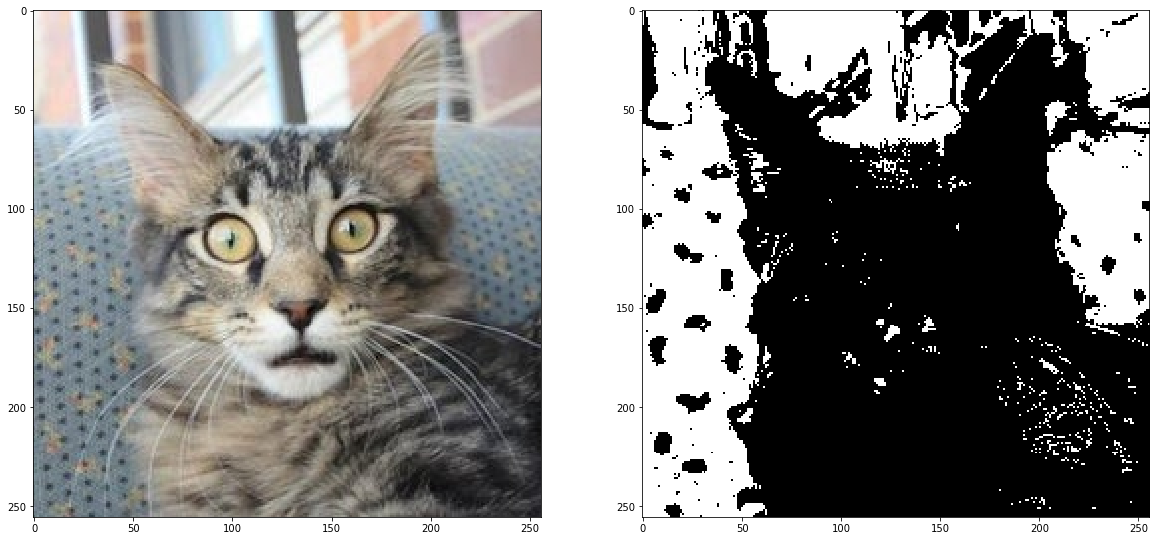

In [221]:
C=5000
gamma=50

svm_model = SVC(kernel='rbf',C=C ,gamma =gamma )
svm_model.fit(X, y)
original_image_flat = np.reshape(original_image/255.0, (original_image.shape[0]*original_image.shape[1] ,3))
y_pred = svm_model.predict(original_image_flat)
of_pred_labels = np.reshape(y_pred, (original_image.shape[0],original_image.shape[1] ))
of_pred_colored = copy.deepcopy(of_pred_labels)
of_pred_colored[of_pred_labels==1] = 0 # cat
of_pred_colored[of_pred_labels==2] = 255 # background

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.imshow(original_image)
ax2.imshow(of_pred_colored, cmap='Greys_r')

# SLIC segmentation

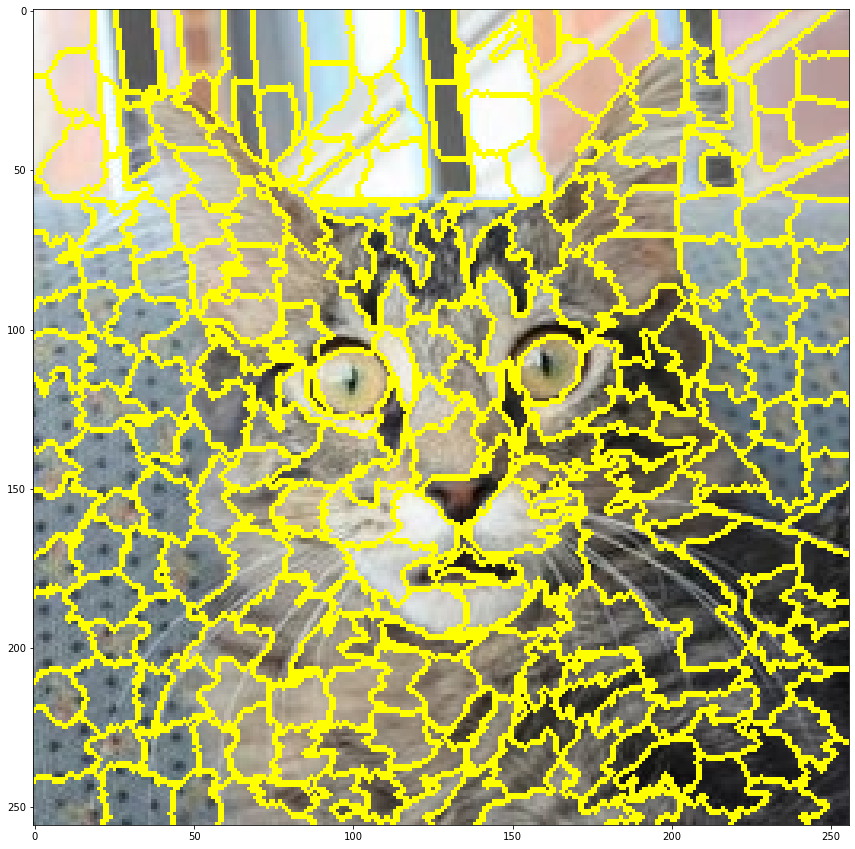

In [222]:
segments = slic(original_image, n_segments=300) # 500
fig = plt.figure(figsize=(15,15))
plt.imshow(mark_boundaries(original_image, segments))

# Merging SLIC segments

merging stage = 0
merging stage = 1
merging stage = 2
merging stage = 3
merging stage = 4
merging stage = 5


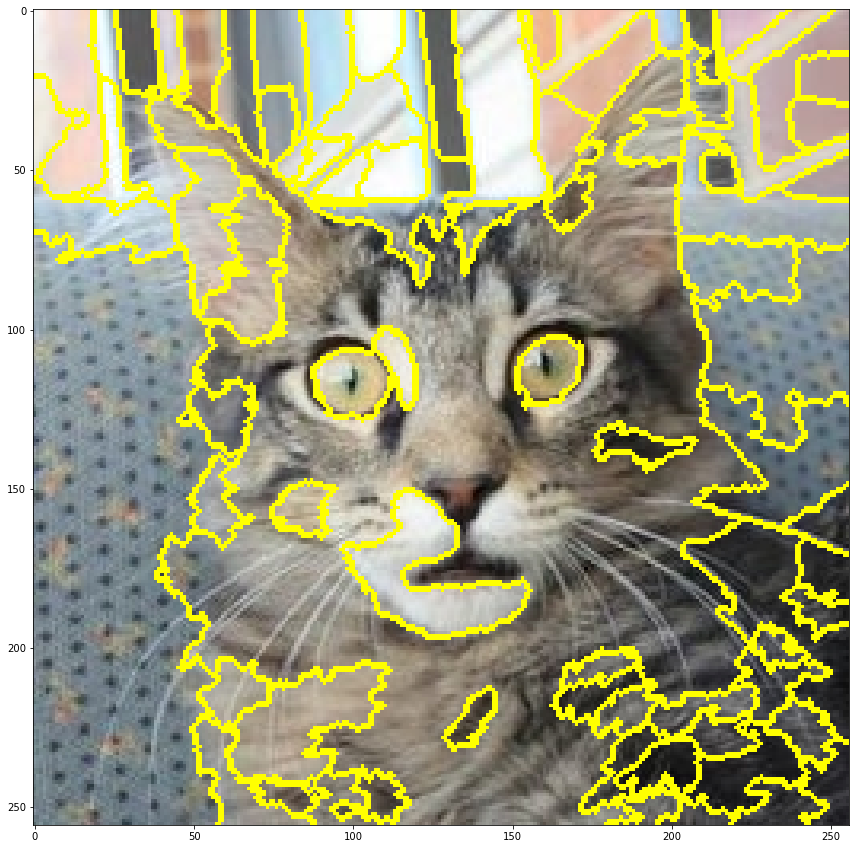

In [224]:
thresh_hold_distance = 0.6
new_segments = mergeNeighbor(original_image, segments, thresh_hold_distance)
fig = plt.figure(figsize=(15,15))
plt.imshow(mark_boundaries(original_image, new_segments))

### Extracting Haralick features from SLIC segments - SVM classification

In [226]:
H_properties_all = [
    ['contrast'],
    ['correlation'],
    ['energy'],
    ['homogeneity'],
#     ['contrast','correlation'],
#     ['contrast','energy'],
#     ['contrast','homogeneity'],
#     ['correlation','energy'],
#     ['correlation','homogeneity'],
#     ['energy', 'homogeneity'],
#     ['contrast','correlation','energy'],
#     ['contrast','correlation','homogeneity'],
#     ['correlation','energy', 'homogeneity'],
#     ['contrast','correlation','energy', 'homogeneity']
]

In [227]:
C=5000
gamma=50
pred_images_all = np.zeros((original_image.shape[0], original_image.shape[1], len(H_properties_all)), dtype=np.uint8)
for k in range(len(H_properties_all)):
    H_properties = H_properties_all[k]
    print(H_properties)
    H_features = H_features_calc(original_image, new_segments, H_properties)
    SLIC_HF_OF_image = np.concatenate((original_image/255.0, H_features),axis=-1 )
    X_H, y_H = get_features_and_labels(SLIC_HF_OF_image, mask)
    SLIC_HF_OF_image_flat = np.reshape(SLIC_HF_OF_image, (SLIC_HF_OF_image.shape[0]*SLIC_HF_OF_image.shape[1],
                                                          SLIC_HF_OF_image.shape[2]))
    svm_model = SVC(kernel='rbf',C=C ,gamma =gamma )
    svm_model.fit(X_H, y_H)

    y_pred = svm_model.predict(SLIC_HF_OF_image_flat)
    of_pred_labels = np.reshape(y_pred, (original_image.shape[0],original_image.shape[1] ))
    of_pred_labels = np.array(of_pred_labels, dtype=np.uint8)
    
    new_labels = np.unique(of_pred_labels)
    of_pred_labels_slic = np.zeros(of_pred_labels.shape, dtype=np.uint8)

    for slic_label in np.unique(new_segments):
        labels_per_seg = of_pred_labels[np.where(new_segments==slic_label)]
        if len(labels_per_seg[labels_per_seg==new_labels[0]])>len(labels_per_seg[labels_per_seg==new_labels[1]]):
            of_pred_labels_slic[new_segments==slic_label] = 0
        else:
            of_pred_labels_slic[new_segments==slic_label] = 255
    pred_images_all[:,:,k] = of_pred_labels_slic

['contrast']
['correlation']
['energy']
['homogeneity']


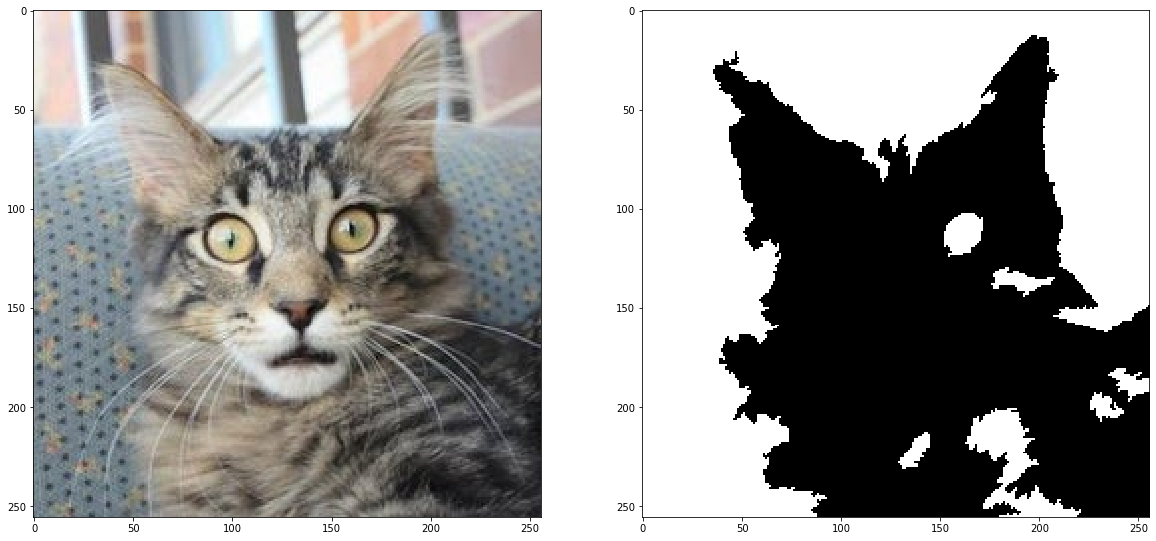

In [228]:
pred_image_all_f = np.ones((original_image.shape[0], original_image.shape[1]), dtype=np.uint8)*255
for i in range(original_image.shape[0]):
    for j in range(original_image.shape[1]):
        label_from_pred_all_images = list(pred_images_all[i,j,:])
        if label_from_pred_all_images.count(0) == len(H_properties_all):
            pred_image_all_f[i,j] = 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.imshow(original_image)
ax2.imshow(pred_image_all_f, cmap='Greys_r')

# Post processing

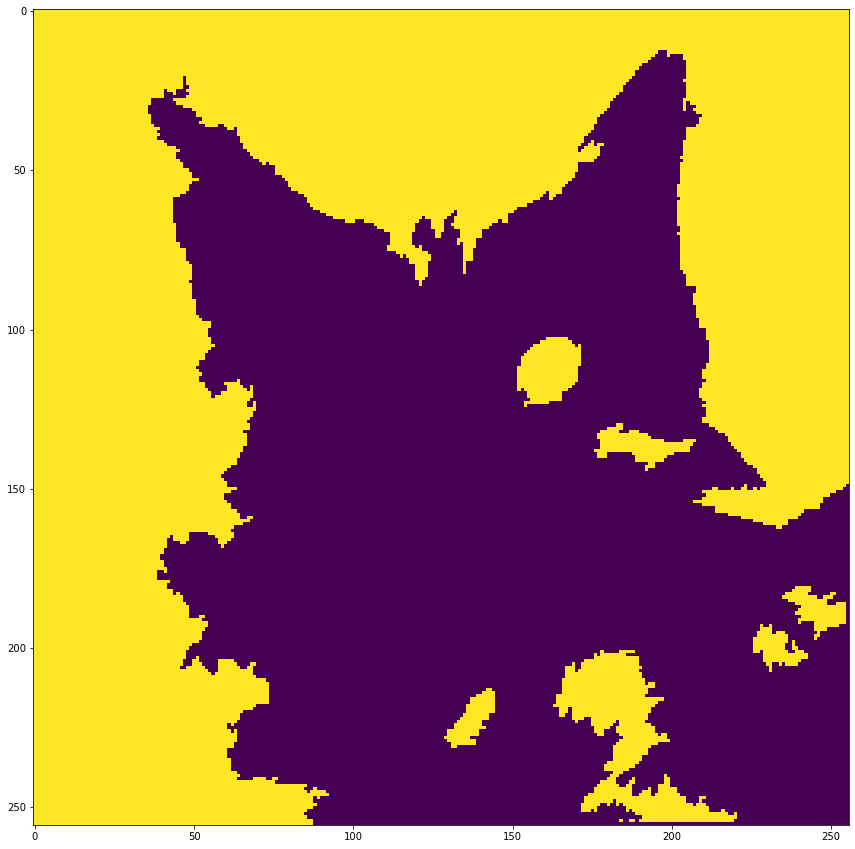

In [229]:
final_pred_image = copy.deepcopy(pred_image_all_f)

for i in range(1,len(final_pred_image[-1,:])):
    if final_pred_image[i-1,-1]==0:
        final_pred_image[i,-1]=0
for i in range(1,len(final_pred_image[:,-1])):
    if final_pred_image[-1,i-1]==0:
        final_pred_image[-1,i]=0
fig = plt.figure(figsize=(15,15))
plt.imshow(final_pred_image)

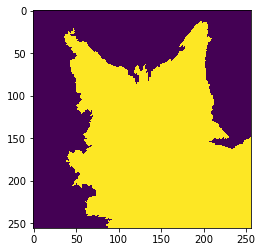

In [230]:
des = cv2.bitwise_not(final_pred_image)
contour,hier = cv2.findContours(des,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

for cnt in contour:
    cv2.drawContours(des,[cnt],0,255,-1)
    
plt.imshow(des)

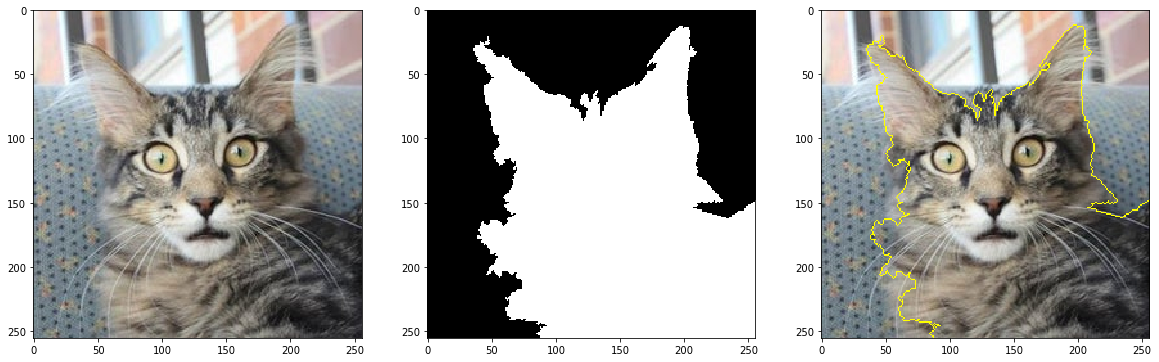

In [231]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,20))
ax1.imshow(original_image)
ax2.imshow(des, cmap='Greys_r')
ax3.imshow(mark_boundaries(original_image, des))